# Project 3 : Predicting soccer games outcome

In [1]:
import pandas as pd
import sqlite3
from datetime import timedelta
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

%matplotlib inline
warnings.filterwarnings("ignore")



### Functions definition

In [2]:
# Functions

def get_goal_diff(row):
    '''
    return goal difference for each row
    '''
    return row['home_team_goal']-row['away_team_goal']

def get_outcome(row):
    '''
    return match outcome for each row 
    1: Home team wins
    2: Draw
    3: Away team wins
    '''
    if row['home_team_goal']>row['away_team_goal']:
        return 1
    elif row['home_team_goal']==row['away_team_goal']:
        return 2
    else: 
        return 3
    
def get_past_history(matches,team, k):
    '''
    for home / away team : calculate % of wins and losses and average goal diff for the last k games
    '''
    
    id=team+'_team_api_id'
    
    columns = ["date", id ,"matches_outcome","matches_goal_diff"]
    a=matches[columns]
    
    a=matches.merge(matches[[id,'matches_outcome','matches_goal_diff', 'date']], on=id, suffixes=('', '_prior'))
    a=a[(a['date'] > a['date_prior'])]
    a=a.sort_values(by=[id,'date','date_prior'], ascending=[1,1,0]).groupby([id,'date']).head(10)
    
    b=a.groupby([id, 'date','matches_outcome_prior']).size().unstack(fill_value=0).reset_index()
    b=b.rename(index=str, columns={1: "matches_"+team+"_past_wins",2: "matches_"+team+"_past_draws",3: "matches_"+team+"_past_losses"})
    b['matches_'+team+'_past_wins'] = b['matches_'+team+'_past_wins'].fillna(0)
    b['matches_'+team+'_past_draws'] = b['matches_'+team+'_past_draws'].fillna(0)
    b['matches_'+team+'_past_losses'] = b['matches_'+team+'_past_losses'].fillna(0)
    b['matches_'+team+'_n_games']=b['matches_'+team+'_past_wins'] +b['matches_'+team+'_past_draws']+b['matches_'+team+'_past_losses']
    b['matches_'+team+'_%_wins']=b['matches_'+team+'_past_wins']/b['matches_'+team+'_n_games']
    b['matches_'+team+'_%_losses']=b['matches_'+team+'_past_losses']/b['matches_'+team+'_n_games']

    #% of wins and losses of the last k games
    res = pd.merge(left=matches, right=b[[id,'date','matches_'+team+'_n_games','matches_'+team+'_%_wins','matches_'+team+'_%_losses']], how='left', on=[id,'date'])

    c=a.groupby([id, 'date'])['matches_goal_diff_prior'].mean().reset_index()
    c=c.rename(index=str, columns={'matches_goal_diff_prior': "matches_"+team+"_average_goal_diff"})
    c["matches_"+team+"_average_goal_diff"]=c["matches_"+team+"_average_goal_diff"]*(team=='home')-c["matches_"+team+"_average_goal_diff"]*(team=='away')
    #average goal diff for the last k games
    res = pd.merge(left=res, right=c, how='left', on=[id,'date'])


    return res 

### Loading data

In [3]:
with sqlite3.connect('soccer/database.sqlite') as con:
    countries = pd.read_sql_query("SELECT * from Country", con)
    matches = pd.read_sql_query("SELECT * from Match", con)
    leagues = pd.read_sql_query("SELECT * from League", con)
    teams = pd.read_sql_query("SELECT * from Team", con)
    players = pd.read_sql_query("SELECT * from Player", con)
    player_attributes = pd.read_sql_query("SELECT * from Player_Attributes", con)
    team_attributes = pd.read_sql_query("SELECT * from Team_Attributes", con)

In [4]:
# matches.dropna(subset = rows, inplace = True)

In [5]:
# pd.set_option('display.max_columns', 500)

In [6]:
matches['date']= pd.to_datetime(matches['date'])
player_attributes['date']= pd.to_datetime(player_attributes['date'])
team_attributes['date']= pd.to_datetime(team_attributes['date'])

In [7]:
matches=matches.sort_values(by=['home_team_api_id','date'], ascending=[1,1])
matches['matches_goal_diff']=matches.apply(get_goal_diff, axis=1)
matches['matches_outcome']=matches.apply(get_outcome, axis=1) 

In [8]:
# let's start by predicting the loss of the home team
y=(matches['matches_outcome']==3)*1
X=matches

### Desciprtive satistics

In [9]:
# X.matches_outcome.value_counts() # 46% W, 29% D, 25% L

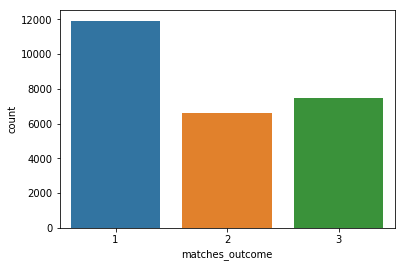

In [10]:
sns.countplot(x = 'matches_outcome',data=X)

In [11]:
# X.matches_goal_diff.value_counts().reset_index().sort_values(by=['index'], ascending=[1])

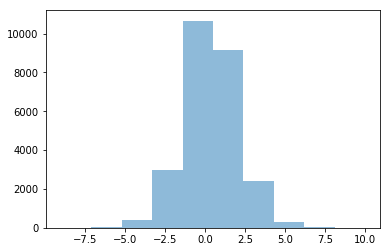

In [12]:
plt.hist(X.matches_goal_diff, alpha=0.5, label='goal_diff');

### Splitting data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=444)

In [14]:
X_train.shape

(18185, 117)

### Features' engineering

We start by using the 10 last games statistcs.  
Later we can change the depth and / or give different weights according to proximity to the considered game.

In [15]:
X_train=get_past_history(X_train,'home',10)

In [16]:
X_train=get_past_history(X_train,'away',10)

In [17]:
X_test=get_past_history(X_test,'home',10)

In [18]:
X_test=get_past_history(X_test,'away',10)

In [19]:
X_train.shape

(18185, 125)

**First selection of features**

In [20]:
# subset of features
columns=['matches_home_average_goal_diff','matches_home_%_wins','matches_home_%_losses', 'matches_home_n_games', \
        'matches_away_average_goal_diff','matches_away_%_wins','matches_away_%_losses', 'matches_away_n_games', \
        'league_id', 'stage', 'season']

columns.extend(['y'])

For now drop observations that do not have at least 10 prvious games.  
Later we can aggregate the results of newly promoted teams to deal with this problem.

In [21]:
df_train=X_train
df_train['y']=y_train.values
# drop rows with a history of less than 10 games
df_train_subset=df_train[(df_train.matches_home_n_games==10) & (df_train.matches_away_n_games==10)]

df_test=X_test
df_test['y']=y_test.values
# drop rows with a history of less than 10 games
df_test_subset=df_test[(df_test.matches_home_n_games==10) & (df_test.matches_away_n_games==10)]

In [22]:
df_train_subset.shape

(13972, 126)

In [23]:
df_train.shape

(18185, 126)

**M1**: Baseline model with : 
- % of matches lost by the home team for the last 10 matches played at home
- % of matches won by the guest teal for the last 10 matches played away

M1's accuracy socre : 0.7115616702872315
M1's precision socre : 0.5568181818181818
M1's recall socre : 0.04066390041493776
M1's f1 socre : 0.07579273008507348
M1's AUC socre : 0.6241867191670739


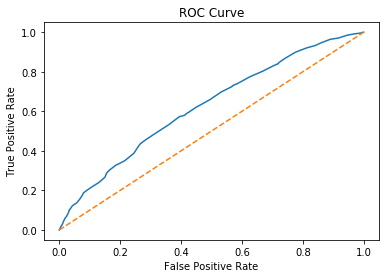

In [24]:
columns=['matches_home_%_losses', \
        'matches_away_%_wins' ]
scaler = preprocessing.StandardScaler().fit(df_train_subset[columns])
X_tr=scaler.transform(df_train_subset[columns]) 
X_te=scaler.transform(df_test_subset[columns]) 

lr = LogisticRegression()
lr.fit(X_tr, df_train_subset['y'])

y_pred = lr.predict(X_te)

print("M1's accuracy socre : " +str(accuracy_score(df_test_subset['y'], y_pred)))
print("M1's precision socre : " +str(precision_score(df_test_subset['y'], y_pred)))
print("M1's recall socre : " +str(recall_score(df_test_subset['y'], y_pred)))
print("M1's f1 socre : " +str(f1_score(df_test_subset['y'], y_pred)))

fpr, tpr, _ = roc_curve(df_test_subset['y'], lr.predict_proba(X_te)[:,1])
plt.plot(fpr, tpr)
x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print("M1's AUC socre : " +str(auc(fpr, tpr)))

**M1:71 % accuracy and 62 % AUC.**

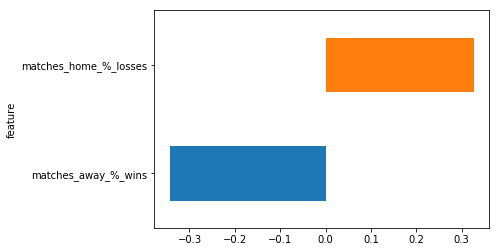

In [25]:
coef=list(zip(columns,lr.coef_.transpose()))
coef=[(e[0],e[1][0]) for e in coef]
coef = sorted(coef, key = lambda x: x[1], reverse=False)
coef = pd.DataFrame(coef, columns=['feature','coef'])
coef.plot(x='feature',y='coef',kind='barh',legend=False)

The coefficients of the features (standardized) : the home team and the guest team statistics seem to have the same importance.

**M2:** let's add the stats of matches played away for the home team and those played at home for the guest team

The logistic regression's accuracy socre : 0.719768283852281
The logistic regression's precision socre : 0.6134020618556701
The logistic regression's recall socre : 0.0987551867219917
The logistic regression's f1 socre : 0.1701215153681201
The logistic regression's AUC socre : 0.6443250411689438


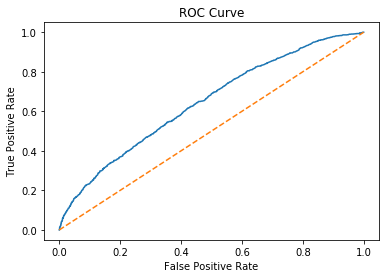

In [26]:
columns=['matches_home_%_wins','matches_home_%_losses', \
        'matches_away_%_wins','matches_away_%_losses' ]
scaler = preprocessing.StandardScaler().fit(df_train_subset[columns])
X_tr=scaler.transform(df_train_subset[columns]) 
X_te=scaler.transform(df_test_subset[columns]) 

lr = LogisticRegression()
lr.fit(X_tr, df_train_subset['y'])

y_pred = lr.predict(X_te)

print("The logistic regression's accuracy socre : " +str(accuracy_score(df_test_subset['y'], y_pred)))
print("The logistic regression's precision socre : " +str(precision_score(df_test_subset['y'], y_pred)))
print("The logistic regression's recall socre : " +str(recall_score(df_test_subset['y'], y_pred)))
print("The logistic regression's f1 socre : " +str(f1_score(df_test_subset['y'], y_pred)))

fpr, tpr, _ = roc_curve(df_test_subset['y'], lr.predict_proba(X_te)[:,1])
plt.plot(fpr, tpr)
x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print("The logistic regression's AUC socre : " +str(auc(fpr, tpr)))

Just a tiny improvement of AUC..

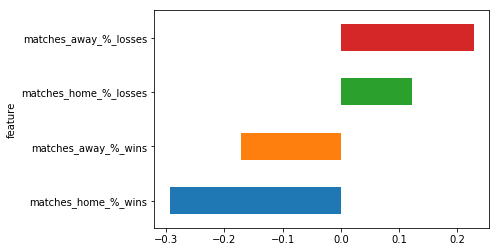

In [27]:
coef=list(zip(columns,lr.coef_.transpose()))
coef=[(e[0],e[1][0]) for e in coef]
coef = sorted(coef, key = lambda x: x[1], reverse=False)
coef = pd.DataFrame(coef, columns=['feature','coef'])
coef.plot(x='feature',y='coef',kind='barh',legend=False)

As expected, the statistics of the home team at home and the guest team away are more relevant.

**M3:** let's try the average goal difference of the 10 last matches played at home by the home team and the 10 last matches played away by the guest team

The logistic regression's accuracy socre : 0.721940622737147
The logistic regression's precision socre : 0.6090534979423868
The logistic regression's recall socre : 0.12282157676348547
The logistic regression's f1 socre : 0.20441988950276244
The logistic regression's AUC socre : 0.6557286267509159


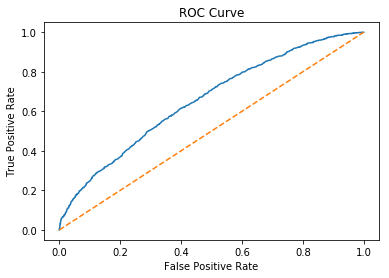

In [28]:
 columns=['matches_home_average_goal_diff', \
        'matches_away_average_goal_diff']
scaler = preprocessing.StandardScaler().fit(df_train_subset[columns])
X_tr=scaler.transform(df_train_subset[columns]) 
X_te=scaler.transform(df_test_subset[columns]) 

lr = LogisticRegression()
lr.fit(X_tr, df_train_subset['y'])

y_pred = lr.predict(X_te)

print("The logistic regression's accuracy socre : " +str(accuracy_score(df_test_subset['y'], y_pred)))
print("The logistic regression's precision socre : " +str(precision_score(df_test_subset['y'], y_pred)))
print("The logistic regression's recall socre : " +str(recall_score(df_test_subset['y'], y_pred)))
print("The logistic regression's f1 socre : " +str(f1_score(df_test_subset['y'], y_pred)))

fpr, tpr, _ = roc_curve(df_test_subset['y'], lr.predict_proba(X_te)[:,1])
plt.plot(fpr, tpr)
x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print("The logistic regression's AUC socre : " +str(auc(fpr, tpr)))

M3 is better than than M1 and M2 as expected (goal differnece has more information that match outcome), but the imporvment is not very important.  
Later : add avearage goal difference of the guest team's matches played at home and the home team's matches played away.

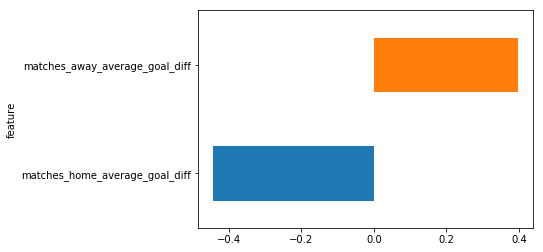

In [30]:
coef=list(zip(columns,lr.coef_.transpose()))
coef=[(e[0],e[1][0]) for e in coef]
coef = sorted(coef, key = lambda x: x[1], reverse=False)
coef = pd.DataFrame(coef, columns=['feature','coef'])
coef.plot(x='feature',y='coef',kind='barh',legend=False)

**M4:** let's put all these features together

The logistic regression's accuracy socre : 0.7243543326092203
The logistic regression's precision socre : 0.6235294117647059
The logistic regression's recall socre : 0.13195020746887967
The logistic regression's f1 socre : 0.21780821917808219
The logistic regression's AUC socre : 0.6555450259724486


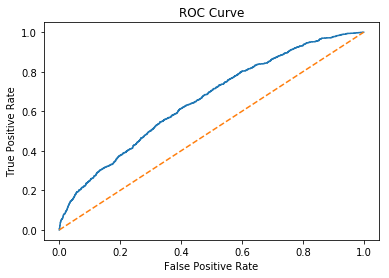

In [31]:
columns=['matches_home_average_goal_diff','matches_home_%_wins','matches_home_%_losses', \
        'matches_away_average_goal_diff','matches_away_%_wins','matches_away_%_losses']
scaler = preprocessing.StandardScaler().fit(df_train_subset[columns])
X_tr=scaler.transform(df_train_subset[columns]) 
X_te=scaler.transform(df_test_subset[columns]) 

lr = LogisticRegression()
lr.fit(X_tr, df_train_subset['y'])

y_pred = lr.predict(X_te)

print("The logistic regression's accuracy socre : " +str(accuracy_score(df_test_subset['y'], y_pred)))
print("The logistic regression's precision socre : " +str(precision_score(df_test_subset['y'], y_pred)))
print("The logistic regression's recall socre : " +str(recall_score(df_test_subset['y'], y_pred)))
print("The logistic regression's f1 socre : " +str(f1_score(df_test_subset['y'], y_pred)))

fpr, tpr, _ = roc_curve(df_test_subset['y'], lr.predict_proba(X_te)[:,1])
plt.plot(fpr, tpr)
x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print("The logistic regression's AUC socre : " +str(auc(fpr, tpr)))

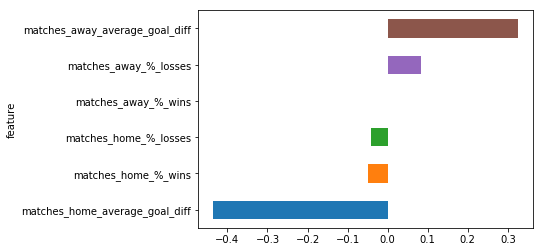

In [32]:
coef=list(zip(columns,lr.coef_.transpose()))
coef=[(e[0],e[1][0]) for e in coef]
coef = sorted(coef, key = lambda x: x[1], reverse=False)
coef = pd.DataFrame(coef, columns=['feature','coef'])
coef.plot(x='feature',y='coef',kind='barh',legend=False)

This model has a lower AUC that M3.

### Next steps

- **Features' engineering :**
    - find the optimal depth / weight more recent games 
    - add direct confrontations
    - Add players and team attributes / lineup  
- **Try other models**
- **Build betting strategies**